In [1]:
### Stage 1: Map Matching

### In Stage 1, the main task is to map all the trajectories to road segments. 
### The basic process will be similar to what we discuss about the HMM paper, 
### but feel free to come to with any “crazy” ideas. (optional)
### Also, think about how you will evaluate the results.

### **Input**: trajectories, 

### **Output**: each GPS point should have one corresponding matched road segment.


In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.functional as F
import os, sys
import math
from shapely.geometry import shape, Point, LineString, MultiLineString
from sklearn.metrics.pairwise import haversine_distances 


RADIUS_OF_EARTH_M = 6371000
MILES_PER_METER = 0.000621371
HOURS_PER_SECOND = 3600.0

In [3]:
# great circle distance
def Euclidean_distance(latitude, longitude, prev_latitude, prev_longitude):
    # convert decimal degrees to radians 
    
    dlon = longitude - prev_longitude # lon2 - lon1 
    dlat = latitude - prev_latitude # lat2 - lat1 
    
    return np.sqrt(dlon**2 + dlat**2)

In [4]:
# great circle distance 
def great_circle_dist(df):
    # convert decimal degrees to radians 
    df = df.copy()
    df = np.deg2rad(df)
    
    longitude = df[:, 3]
    latitude = df[:, 2]
    prev_longitude = df[:, 1]
    prev_latitude = df[:, 0]
    
    # haversine formula 
    dlon = longitude - prev_longitude # lon2 - lon1 
    dlat = latitude - prev_latitude # lat2 - lat1 
    
    # a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    a = np.add(np.square(np.sin(dlat / 2)),
               np.multiply(np.cos(prev_latitude), 
                           np.multiply(np.cos(latitude), np.square(np.sin(dlon / 2)))
                          )
              )
    
    # c = 2 * asin(sqrt(a)) 
    c = np.arcsin(np.sqrt(a)) * 2
    
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return r * c * 1000

In [5]:
def minDistance(A, B, E) :
 
    # vector AB
    AB = [None, None];
    AB[0] = B[0] - A[0];
    AB[1] = B[1] - A[1];
 
    # vector BE
    BE = [None, None];
    BE[0] = E[0] - B[0];
    BE[1] = E[1] - B[1];
 
    # vector AE
    AE = [None, None];
    AE[0] = E[0] - A[0];
    AE[1] = E[1] - A[1];
 
    # Variables to store dot product
 
    # Calculating the dot product
    AB_BE = AB[0] * BE[0] + AB[1] * BE[1];
    AB_AE = AB[0] * AE[0] + AB[1] * AE[1];
 
    # Minimum distance from
    # point E to the line segment
    reqAns = 0;
 
    # Case 1
    if (AB_BE > 0) :
 
        # Finding the magnitude
        y = E[1] - B[1];
        x = E[0] - B[0];
        reqAns = math.sqrt(x * x + y * y);
 
    # Case 2
    elif (AB_AE < 0) :
        y = E[1] - A[1];
        x = E[0] - A[0];
        reqAns = math.sqrt(x * x + y * y);
 
    # Case 3
    else:
 
        # Finding the perpendicular distance
        x1 = AB[0];
        y1 = AB[1];
        x2 = AE[0];
        y2 = AE[1];
        mod = math.sqrt(x1 * x1 + y1 * y1);
        reqAns = abs(x1 * y2 - y1 * x2) / mod;
    return reqAns;

In [6]:
## HMM model
class HMMModel(nn.Module):
    def __init__(self, sigma = 4.07, beta=3.0, normalize=True, 
                 prob_floor=0.0, n = 0, viterbi_trellis=[], prev_candidate_roads = []):
        self.sigma = sigma
        self.beta = beta
        self.normalize = normalize
        self.prob_floor = min(max(prob_floor, 0), 1)
        self.obs_history = []
        self.n = n
        self.weights = np.zeros((1, self.n))
        self.particles = np.array([])
        self.viterbi_trellis = viterbi_trellis  # list of particle np arrays
        self.prev_candidate_roads = prev_candidate_roads
#         self.viterbi_trellis_idx = viterbi_trellis_idx  # list of np arrays, columns candidate road indices, particle indices
      
    # TODO?: get the 𝑥𝑡,𝑖 (the perpendicular point from the trip point to the road segments)
    def apply_emission_model(self, sampled_states, obs_coords):
        probs = []
        for obs in sampled_states:
            # ‖𝑧𝑡 − 𝑥𝑡,𝑖‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒
            dist_obs_roads = obs[1].ShortestDistance
            
            # 𝑝(𝑧𝑡|𝑟𝑖)
            probs.append(np.exp(np.power(dist_obs_roads / self.sigma, 2) * (-0.5)) * (1 / (math.sqrt(2 * math.pi) * self.sigma)))

        # Normalize result
        # TODO: Answer the question: Why do we need to normalize
        if self.normalize:
            probs = probs / np.sum(probs)
        return probs
    
    def apply_transition_model(self, candidate_roads, dist_prev):
        # TODO: terminate the search for a route when ‖𝑥𝑡,𝑖 − 𝑥𝑡+1,𝑗‖𝑟𝑜𝑢𝑡𝑒 
        # becomes greater than ‖𝑧𝑡 − 𝑧𝑡+1‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒 by 2000 meters
        # or more, and assign a probability of zero.
        probs = []
        # go through the candidate_roads and check the distance with the previous candidate_roads
        #
        # O -> 1
        # O -> 1
        # O -> 1
        # O -> 1
        # NOTE: ‖𝑧𝑡 − 𝑧𝑡+1‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒 is given by dist_prev
        for point in candidate_roads:
            prob = []
            for prev_point in self.prev_candidate_roads:
                # calculate ‖𝑥𝑡,𝑖 − 𝑥𝑡+1,𝑗‖𝑟𝑜𝑢𝑡𝑒
                # TODO: calculate the distance with the perpendicular point
                dist_road = Euclidean_distance(point[1].StartNodeLat, point[1].StartNodeLong, prev_point[1].StartNodeLat, prev_point[1].StartNodeLong)
                
                # calculate the difference between ‖𝑧𝑡 − 𝑧𝑡+1‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒 and ‖𝑥𝑡,𝑖 − 𝑥𝑡+1,𝑗‖𝑟𝑜𝑢𝑡𝑒
                diff_dist = np.abs(np.subtract(dist_road, dist_prev))
                
                # calculate the transition probability
                prob.append(np.exp(-diff_dist / self.beta) * (1 / self.beta))
            probs.append(prob)
        
        # Normalize result?
        # TODO: Answer the question: Why do we need to normalize
        if self.normalize:
            probs = probs / np.sum(probs)
        return probs  # the probs is a list of lists transition prob
    
    def update_dist(self, obs, candidate_roads, num_iter, total_num, max_dist2=None):
        self.n = total_num
        longitude = obs[1].longitude
        latitude = obs[1].latitude
        dist_from_prev_m = obs[1].dist_from_prev_m
        
        obs_coords = [latitude, longitude] 
        dist_prev = dist_from_prev_m
        self.obs_history.append(obs_coords)
        
        # transition probability
        if num_iter > 1:
            trans_probs = self.apply_transition_model(candidate_roads, 
                                                      dist_prev) # (n * c, 1) first n rows for first candidate, etc.
            # Aggregate probs by candidate roads
            for trans_prob in trans_probs:
                print(trans_prob)
                print(self.weights)
                print(np.multiply(trans_prob, self.weights))
                return "Aborted"
#             trans_probs_agg = np.sum(trans_probs)
#             print(trans_probs_agg)
            
            trans_probs_split = np.array(np.split(trans_probs, self.n, axis=0))  # (n, c, 1)
            trans_probs_agg = np.sum(trans_probs_split, axis=0)  # (c, 1)
            
            # Sample new states
            # Sample new states; index into candidate roads
            sampled_states_idx = np.random.choice(range(len(candidate_roads)), 
                                                  self.n, 
                                                  list(trans_probs_agg.flatten()))  # (n, )
            sampled_states = []
            for i in range(len(sampled_states_idx)):
                sampled_states.append(candidate_roads[sampled_states_idx[i]])  # (n, 2)
            # alph𝑡(i)
            sampled_states_best_prior = np.argmax(sampled_states_idx)  # (n, 1)
#             sampled_states_best_prior = sampled_states_idx.reshape(-1, 1)

            return "Aborted"
        else:
            sampled_states = candidate_roads
            # alph𝑡(i) when t = 0
            sampled_states_best_prior = 1
        
        # emission probabilities
        emission_probs = self.apply_emission_model(sampled_states, obs_coords)  # (n, 1) 
        
        
        # Joint prob, for viterbi backtracking. Do this in the log domain.  
        if num_iter > 1:
            # May want to do this in the log domain?
            joint_prob = np.add(
                np.add(np.log(sensor_probs), np.max(np.log(trans_probs_split), axis=0)[sampled_states_idx]),  # (n, 1)
                self.weights
                )
        
        # the initial state probability 𝜋𝑖
        new_particles = emission_probs * sampled_states_best_prior
#         index = np.where(new_particles == np.max(new_particles))[0][0]
    
        # Best prior state/particle for a given candidate state, for viterbi backtracking. 
        if num_iter > 1:
            # find the maximum road segment
            # viterbi_trellis = candidate_roads[np.where(new_particles == np.max(new_particles))[0][0]]
            viterbi_trellis_list = []
            for probs in new_particles:
                viterbi_trellis_list.append([obs[1].StartNodeLat, obs[1].StartNodeLong])
                
            self.viterbi_trellis.append(viterbi_trellis_list)
            self.viterbi_trellis_idx.append(sampled_states_best_prior)
        else:
            self.viterbi_trellis.append(new_particles)
            joint_prob = new_particles  # Initialization probability
        
        self.weights = joint_prob
        
        self.prev_candidate_roads = candidate_roads
        
        self.particles = new_particles
        
        # Estimate current particle filter fit quality of hypotheses to data; should research good metrics more.
        fit_quality = [np.max(self.weights), np.mean(self.weights), np.median(self.weights)]
        
        return fit_quality
    
    def viterbi(self):
        # Start with the last observation to the viterbi trellis
        best_last_state_idx = np.argmax(self.weights)
        backtracked_states = []
        # Backtrack through the viterbi trellis (#obs, n, 2) actual lat/long states
        for j in range(len(self.viterbi_trellis) - 1):
            # for that 'candidate road,' the particle index (col 1)
            best_last_state = self.viterbi_trellis[j][best_last_state_idx]
            best_last_state_idx = self.viterbi_trellis_idx[j]
            backtracked_states.append(best_last_state)
        # Put in chronological order
        backtracked_states = backtracked_states[::-1]
        return backtracked_states

In [7]:
# preprocess the data
def preprocess_traces(df, sigma=4.07):
    data = df.copy()
    data[["prev_latitude", "prev_longitude"]] = data[["latitude", "longitude"]].shift(1)
    # Ignore warning about invalid value in arcsin (nan)
    data["dist_from_prev_m"] = great_circle_dist(data[["prev_latitude", "prev_longitude", "latitude", "longitude"]].values)  # 1.93 sec
    # Take cumsum of dist
    dist_cum = data.dist_from_prev_m.cumsum()
    # Select points closest to multiples of 2*sigma, in cumsum dist
    dist_cum_idx = dist_cum // (2 * sigma)
    filter_idx = np.subtract(dist_cum_idx, dist_cum_idx.shift(1)) == 0  # 12% of rows eliminated 
    data = data[~filter_idx]
    
    # seperate the route based on the occupancy
    trips_list = []
    trip = []
    # for loop all the point
    for obs in data.iterrows():
        # if this point's occupancy is 1
        if obs[1].occupancy == 1:
            trip.append(obs)
        else:
            trips_list.append(trip)
            trip = []
    trips_list = [x for x in trips_list if x != []]
    return trips_list

In [8]:
# preprocess the Map
def preprocess_Map(data_edge, data_node):
    data_node.rename(columns = {'NodeID':'StartNodeID'}, inplace = True)
    data_node.rename(columns = {'Longitude':'StartNodeLong'}, inplace = True)
    data_node.rename(columns = {'Latitude':'StartNodeLat'}, inplace = True)
    df_merge = pd.merge(data_edge, data_node, on="StartNodeID")

    data_node.rename(columns = {'StartNodeID':'EndNodeID'}, inplace = True)
    data_node.rename(columns = {'StartNodeLong':'EndNodeLong'}, inplace = True)
    data_node.rename(columns = {'StartNodeLat':'EndNodeLat'}, inplace = True)
    df_merge = pd.merge(df_merge, data_node, on="EndNodeID")
    return df_merge

In [9]:
# get the training path
train_path = './training'
Node_path = './road network in CA/node.txt'
Edge_path = './road network in CA/edge.txt'

In [11]:
# get the Map
data_edge = pd.read_csv(Edge_path, sep=' ')
data_node = pd.read_csv(Node_path, sep=' ')

# create map
Map = preprocess_Map(data_edge, data_node)

# create SF roads df
df_node_SF = Map[Map['StartNodeLong'].between(-122.524, -122.345, inclusive=True)]
df_node_SF = df_node_SF[df_node_SF['StartNodeLat'].between(37.702, 37.812, inclusive=True)]
df_node_SF.reset_index(inplace = True, drop = True)

C:\Users\z1297\AppData\Local\Temp\ipykernel_12028\296047548.py:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_node_SF = Map[Map['StartNodeLong'].between(-122.524, -122.345, inclusive=True)]
C:\Users\z1297\AppData\Local\Temp\ipykernel_12028\296047548.py:10: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_node_SF = df_node_SF[df_node_SF['StartNodeLat'].between(37.702, 37.812, inclusive=True)]


In [46]:
# import intersections dataset

street_path = './street_intersections.csv'
df_intersections_original = pd.read_csv(street_path, sep=',')

# sort in node order
df_intersections_original = df_intersections_original.sort_values(by=['CNN', 'ST_TYPE'], ascending=[True, True])
df_intersections_original.reset_index(inplace = True, drop = True)

# get only coordinates
df_intersections = df_intersections_original['the_geom']


# extract coordinates from each intersection 
import re

df_street = pd.DataFrame()
df_street[["Lat","Long"]] = None
Lats = []
Longs = []

for i in range(len(df_intersections)):
    coords = []
    temp = df_intersections[i].split()

    for item in temp:
        coords.extend(re.findall('[-+]?\d*\.?\d+', item))

    coords = list(map(float, coords)) # convert strings to float
    Lats.append(coords[1])
    Longs.append(coords[0])

df_street['Lat'] = Lats
df_street['Long'] = Longs


# sort by coordinates
#df_street = df_street.sort_values(by=['Lat', 'Long'], ascending=[True, True])


# reduce dataframe for testing
df_street = df_street[df_street['Long'].between(-122.4363, -122.3774, inclusive=True)]
df_street = df_street[df_street['Lat'].between(37.7669, 37.8109, inclusive=True)]
df_street.reset_index(inplace = True, drop = True)

C:\Users\z1297\AppData\Local\Temp\ipykernel_12028\3287835623.py:42: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_street = df_street[df_street['Long'].between(-122.4363, -122.3774, inclusive=True)]
C:\Users\z1297\AppData\Local\Temp\ipykernel_12028\3287835623.py:43: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_street = df_street[df_street['Lat'].between(37.7669, 37.8109, inclusive=True)]


In [14]:
# get all the files in the training folder
all_files = [f for f in os.listdir(train_path)]

# read the 1st file in the folder as a test case
train_df = pd.read_csv(os.path.join(train_path, all_files[1]), sep=" ", index_col=None, header=None, 
                      names=['latitude', 'longitude', 'occupancy', 'time'])

# convert the time from unix into date time
train_df.loc[:, ["time"]] = pd.to_datetime(train_df.time, origin="unix", unit='s')

# preprocess the data
trips_list = preprocess_traces(train_df)

# pick one trip for HMM training
trip = trips_list[4]

# replace the great circle distance with the euclidean distance
for x in trip:
    x[1].dist_from_prev_m = Euclidean_distance(x[1].latitude, x[1].longitude, x[1].prev_latitude, x[1].prev_longitude)

In [15]:
# get the candidate road
# TODO: 
# Since we know we are tracking ordinary vehicles on public streets, if a 
# calculated route would require the vehicle to exceed a speed of 50 m/s 
# (112 miles per hour, 180 kilometers per hour), or travel in excess of 
# three times the posted speed limit, we consider the route to be unreasonable,
# and set its probability to zero.
def get_candidate_roads(Map, data):
    # [candidate road for time 0, candidate road for time 1,....]
    candidate_roads = [] 
    # let's get the candidate roads for each time t
    for obs in data:
        # get the lat and long for the point
        z_long = obs[1].longitude
        z_lat = obs[1].latitude
        z = [z_lat, z_long]
        # match the coords and the dataset
        candidate_road = []
        for edge in Map.iterrows():
            p1 = np.array([edge[1].StartNodeLat, edge[1].StartNodeLong])
            p2 = np.array([edge[1].EndNodeLat, edge[1].EndNodeLong])
            p3 = np.array(z)
            # calculate the distance from the point to the road
            # TODO: convert this euclidance distance to the Great Circle
            d = minDistance(p1, p2, p3)
            # different
            # e = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
            
            # TODO: any road segment more than 200 meters away from the GPS point.
            if d < 0.05:
                edge[1]['ShortestDistance'] = d
                candidate_road.append(edge)
        # TODO: When a break is detected between time step 𝑡 and time step 𝑡 + 1, 
        # we remove measured points 𝑧𝑡 and 𝑧𝑡+1 from the model, and check to see 
        # if the break has been healed. The break is considered healed if the 
        # measured points at 𝑡 − 1 and 𝑡 + 2 lead to a reconnection in the HMM 
        # after rechecking the points with the bulleted conditions above. If the 
        # break is still present, we continue to remove the points on either side 
        # of the break until either the break is healed, or the break is more than 
        # 180 seconds long. 
        if len(candidate_road) == 0:
            print("No matching roads found within max road distance! Aborting particle filter.")
            return None
        candidate_roads.append(candidate_road)
    return candidate_roads

candidate_roads = get_candidate_roads(Map, trip)

In [16]:
# training
model = HMMModel()

def train(data, candidate_roads):
    data = data.copy()
    num_iter = 0
    converged = False
    for obs in data:
        num_iter += 1
        fit_quality = model.update_dist(obs, candidate_roads[num_iter-1], num_iter, len(data))
        if fit_quality == "Aborted":
            return "Aborted"
        print("On iteration %d, fit quality of MAX %3.2f, MEAN %3.2f, MEDIAN %3.2f" % 
              (num_iter, fit_quality[0], fit_quality[1], fit_quality[2]))
    print("Done.")

train(trip, candidate_roads)

On iteration 1, fit quality of MAX 0.06, MEAN 0.06, MEDIAN 0.06
[0.00420306 0.00420471 0.00420471 0.00420492 0.00412072 0.00412175
 0.00413335 0.00412865 0.00412865 0.00414945 0.00412865 0.00420093
 0.00417178 0.00415832 0.0041538  0.00412066]
[0.06249685 0.06249893 0.06249808 0.06249927 0.06250009 0.06250073
 0.06250073 0.06250059 0.06250048 0.06250084 0.06249998 0.06250098
 0.06250128 0.06250132 0.06250127 0.06249858]
[0.00026268 0.00026279 0.00026279 0.0002628  0.00025755 0.00025761
 0.00025834 0.00025804 0.00025804 0.00025934 0.00025804 0.00026256
 0.00026074 0.0002599  0.00025962 0.00025754]


'Aborted'

In [17]:
backtracked_trace = model.viterbi()
print(backtracked_trace)

[]


[[37.78703, -122.41139], [37.78739, -122.40823], [37.79258, -122.40776], [37.79475, -122.40801], [37.7994, -122.40903]]


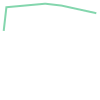

In [18]:
# print(trip[1].latitdue)
trip_list = []
for point in trip:
    trip_list.append([point[1].latitude, point[1].longitude])
print(trip_list)
LineString(trip_list)

In [19]:
trip_list = []
for point in backtracked_trace:
    trip_list.append([point[0], point[1]])
print(trip_list)
LineString(trip_list)

[]


In [20]:
# libraries for map visualization

import networkx as nx
import folium

In [21]:
# Add the standard road network
network_fg = folium.FeatureGroup(name='Road Network')

for index, row in df_node_SF.iterrows():

    # Get the coordinates of the start and end nodes at current index
    start_coord = [row['StartNodeLat'], row['StartNodeLong']]
    end_coord = [row['EndNodeLat'], row['EndNodeLong']]

    # Draw nodes
    node_start = folium.Marker([start_coord[0], 
                   start_coord[1]],
                  popup=(df_node_SF['StartNodeID'][index]),
                 icon = folium.Icon(color='green',icon='plus'))

    node_end = folium.Marker([end_coord[0], 
                   end_coord[1]],
                  popup=(df_node_SF['EndNodeID'][index]),
                 icon = folium.Icon(color='blue',icon='plus'))

    # Draw road segments between nodes
    edges = folium.PolyLine(locations=[start_coord, end_coord], weight=3, color='Red')
    
    # Add the polyline to the feature group
    network_fg.add_child(edges)
    network_fg.add_child(node_start)
    network_fg.add_child(node_end)

In [22]:
# Add the matched roads
matched_fg = folium.FeatureGroup(name='Matched Roads')

for i in range(len(trip_list)):

    # Draw traces
    if i < len(trip_list)-1:
        traces = folium.PolyLine(locations=[trip_list[i], trip_list[i+1]], weight=3, color='Green')
    
    # Add the polyline to the feature group
    matched_fg.add_child(traces)

In [23]:
# calculate distance from node_z to line between node_x and node_y

# create example nodes 
distance_fg = folium.FeatureGroup(name='distance')

node_x_coord = [37.7900, -122.5500]
node_y_coord = [37.7950, -122.5300]
node_z_coord = [37.7990, -122.5450]

node_x = folium.Marker([node_x_coord[0], node_x_coord[1]],
                  popup=('Latitude: 37.7900 Longitude: -122.5500'),
                 icon = folium.Icon(color='green',icon=''))
node_y = folium.Marker([node_y_coord[0], node_y_coord[1]],
                  popup=('Latitude: 37.7900 Longitude: -122.5300'),
                 icon = folium.Icon(color='red',icon=''))
node_z = folium.Marker([node_z_coord[0], node_z_coord[1]],
                  popup=('Latitude: 37.7950 Longitude: -122.5450'),
                 icon = folium.Icon(color='blue',icon=''))
line = folium.PolyLine(locations=[node_x_coord, node_y_coord], weight=3, color='Black')

distance_fg.add_child(node_x)
distance_fg.add_child(node_y)
distance_fg.add_child(node_z)
distance_fg.add_child(line)

In [24]:
import math

def get_perpendicular_point(point, line):
    # point: (x, y)
    # line: ((x1, y1), (x2, y2))
    
    x, y = point
    x1, y1 = line[0]
    x2, y2 = line[1]
    
    # calculate the slope of the line
    if x2 - x1 == 0:
        # vertical line
        x_intersect = x1
        y_intersect = y
    else:
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
    
        # calculate the intersection point of the line and the perpendicular line
        x_intersect = (slope*y + x - slope*intercept) / (slope**2 + 1)
        y_intersect = (slope*x_intersect) + intercept
        
    return x_intersect, y_intersect

line = [node_x_coord, node_y_coord]
closest_road_coord = get_perpendicular_point(node_z_coord, line)
print(closest_road_coord)

(37.79170588235295, -122.54317647058821)


In [25]:
# calculate node_v coordinates

node_v = folium.Marker([closest_road_coord[0], closest_road_coord[1]],
                  popup=('V'),
                 icon = folium.Icon(color='black',icon=''))
distance_fg.add_child(node_v)

In [26]:
#print(trip[1][1])
#print((len(trip[1][1])))
print((len(candidate_roads[0])))
print((len(candidate_roads[1])))
print(range(len(candidate_roads[0])))
print(candidate_roads[0][15][1])
print(candidate_roads[0][0][1][4])


16
15
range(0, 16)
EdgeID              8833.000000
StartNodeID         8663.000000
EndNodeID           8664.000000
L2Distance             0.014952
StartNodeLong       -122.402611
StartNodeLat          37.749901
EndNodeLong         -122.400658
EndNodeLat            37.735077
ShortestDistance       0.038153
Name: 8841, dtype: float64
-122.459587


In [28]:
print(range(len(df_street)))
print(df_street.loc[1, ['Lat']][0])

range(0, 4186)
37.76690344477832


In [49]:
# plot intersections 
road_fg = folium.FeatureGroup(name='Road Network')

for i in range(len(df_street)):

    # Draw traces
    current_coord = [df_street.loc[i, ['Lat']][0], df_street.loc[i, ['Long']][0]]
    if i > 0:
        previous_coord = [df_street.loc[i-1, ['Lat']][0], df_street.loc[i-1, ['Long']][0]]

        if ((current_coord[0]-previous_coord[0]) < 0.0019) and ((current_coord[1]-previous_coord[1]) < 0.0019):
            traces = folium.PolyLine(locations=[previous_coord, current_coord], weight=3, color='Red')

    # Draw nodes
    node = folium.Marker(current_coord,
                  popup=(current_coord),
                 icon = folium.Icon(color='blue',icon=''))

    # Add to the feature group
    road_fg.add_child(traces)
    #road_fg.add_child(node)


In [81]:
print(trips_list[0][0][1])

latitude                        37.7852
longitude                    -122.40486
occupancy                             1
time                2008-06-10 08:46:07
prev_latitude                  37.78492
prev_longitude               -122.40495
dist_from_prev_m               32.12345
Name: 21, dtype: object


In [85]:
# Create a map centered at San Francisco
sf_map = folium.Map(location=[37.759457, -122.444781], zoom_start=12, prefer_canvas=True, control_scale=True)

In [86]:
# Trip picked for HMM Training
trip_fg = folium.FeatureGroup(name='All Trips for HMM Training')

for t in range(len(trips_list)):

    for i in range(len(trips_list[t])):

        # Draw traces
        current_coord = [trips_list[t][i][1][0], trips_list[t][i][1][1]]
        previous_coord = [trips_list[t][i][1][4], trips_list[t][i][1][5]]
        traces = folium.PolyLine(locations=[previous_coord, current_coord], weight=3, color='Blue')
        
        # Draw nodes
        node_end = folium.Marker(current_coord,
                    popup=('End'),
                    icon = folium.Icon(color='red',icon=''))

        node_prev = folium.Marker(previous_coord,
                    popup=('Previous'),
                    icon = folium.Icon(color='blue',icon=''))

        # Add to the feature group
        trip_fg.add_child(traces)
        #trip_fg.add_child(node_end)
        #trip_fg.add_child(node_prev)

# Add the feature groups to the map
sf_map.add_child(trip_fg)

KeyboardInterrupt: 

In [ ]:
# Add layer control feature
folium.LayerControl().add_to(sf_map)

# Add click for coords feature
#sf_map.add_child(folium.LatLngPopup())


# Manually get road network
#sf_map.add_child(folium.ClickForMarker())

# save map
sf_map.save('SF_MAP.html')

# display map
sf_map

KeyboardInterrupt: 